In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
class OrderParameter:

    # name should be unique to the Order Parameter being defined
    # In other words for every possible pair of OP's x and y, (x.name != y.name) must be true
    def __init__(self, name, traj):
        self.name = name
        self.traj = traj
        
    def __eq__(self, other):
        return self.name == other.name
    
    def __hash__(self):
        return hash(self.name)
        
    def __str__(self):
        return str(self.name)

In [3]:
def distortion(centers, ops, mut):
    dis = 0.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        dis = dis + (min_val * min_val)
    return 1 + (dis ** (0.5))

In [4]:
class DissimilarityMatrix:

    def __init__(self, max_OPs, mut):
        self.max_OPs = max_OPs
        self.matrix = [[] for i in range(max_OPs)]
        self.mut = mut
        self.OPs = []

    def add_OP(self, OP):
        if len(self.OPs) == self.max_OPs:
            mut_info = []
            existing = []
            for i in range(len(self.OPs)):
                mut_info.append(self.mut.iqr(self.OPs[i], OP))
                product = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        product = product * self.matrix[i][j]
                existing.append(product)
            update = False
            difference = None
            for i in range(len(self.OPs)):
                candidate_info = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        candidate_info = candidate_info * mut_info[j]
                if candidate_info > existing[i]:
                    update = True
                    if difference == None:
                        difference = candidate_info - existing[i]
                        old_OP = i
                    else:
                        if (candidate_info - existing[i]) > difference:
                            difference = candidate_info - existing[i]
                            old_OP = i
            if update == True:
                mut_info[old_OP] = self.mut.iqr(OP, OP)
                self.matrix[old_OP] = mut_info
                self.OPs[old_OP] = OP
                for i in range(len(self.OPs)):
                    self.matrix[i][old_OP] = mut_info[i]
        else:
            for i in range(len(self.OPs)):
                mut_info = self.mut.iqr(OP, self.OPs[i])
                self.matrix[i].append(mut_info)
                self.matrix[len(self.OPs)].append(mut_info)
            self.matrix[len(self.OPs)].append(self.mut.iqr(OP, OP))
            self.OPs.append(OP)
        
    def reduce(self):
        min_val = 10
        index = -1
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                index = i
                min_val = product
        self.matrix.pop(index)
        for i in range(len(self.matrix)):
            self.matrix[i].pop(index)
        self.OPs.pop(index)
        
    def min_product(self):
        min_val = 10
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                min_val = product
        return min_val
    
    def get_OPs(self):
        return self.OPs
    
    def __str__(self):
        output = ""
        output = output + "OPs:\n"
        for i in self.OPs:
            output = output + str(i) + "\n"
        output = output + "\nMatrix:\n"
        for i in self.matrix:
            for j in i:
                output = output + str(j) + " "
            output = output + "\n"
        return output
                

In [5]:
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [6]:
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [7]:
class Memoizer:
    
    def __init__(self):
        self.memo = {}
        self.bins = 20
        
    def iqr(self, OP1, OP2):
        index = str(OP1.name) + " " + str(OP2.name)
        if index in self.memo:
            return self.memo[index]
        else:
            x = OP1.traj
            y = OP2.traj
            p_x = d1_bin(x, self.bins)
            p_y = d1_bin(y, self.bins)
            p_xy = d2_bin(x, y, self.bins)

            info = 0
            entropy = 0

            for i in range(len(p_x)):
                for j in range(len(p_y)):
                    if p_xy[i][j] != 0:
                        entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                        info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

            if ((1 - (info / entropy)) < 0):
                output = 0.0
            else:
                output = (1 - (info / entropy))
            self.memo[index] = output
            return output
    
    def __str__(self):
        print(len(self.memo))

In [8]:
def grouping(new_OPs, all_OPs, mut):
    groups = [[] for i in range(len(new_OPs))]
    for OP in all_OPs:
        group = 0
        for i in range(len(new_OPs)):
            tmp = mut.iqr(OP, new_OPs[i])
            if tmp < mut.iqr(OP, new_OPs[group]):
                group = i
        groups[group].append(OP)
    return groups

In [9]:
def group_evaluation(OPs, mut):
    
    center = OPs[0]
    min_distortion = distortion([OPs[0]], OPs, mut)
    
    for i in OPs:
        tmp = distortion([i], OPs, mut)
        if tmp < min_distortion:
            center = i
            min_distortion = tmp

    return center

In [10]:
def cluster(ops, seeds, mut):
    
    old_centers = []
    centers = copy.deepcopy(seeds)
    
    while (set(centers) != set(old_centers)):
        
        old_centers = copy.deepcopy(centers)
        centers = []
        groups = grouping(old_centers, ops, mut)
        
        for i in range(len(groups)):
            result = group_evaluation(groups[i], mut)
            centers.append(result)

    return centers


In [11]:
def fix_distortion(lst):
    for i in range(len(lst) - 1):
        index = len(lst) - i - 1
        if lst[index] < lst[index - 1]:
            lst[index - 1] = lst[index]

In [24]:
def find_ops(old_ops, max_outputs):
    
    mut = Memoizer()
    matrix = DissimilarityMatrix(max_outputs, mut)
    
    for i in old_ops:
        matrix.add_OP(i)
        
    for i in old_ops[::-1]:
        matrix.add_OP(i)
    
    tmp = copy.deepcopy(matrix)
    distortion_array = []
    num_array = []
    str_num_array = []

    while (len(tmp.OPs) > 0):
        num_array.append(len(tmp.OPs))
        str_num_array.append(str(len(tmp.OPs)))
        seed = []
        for i in tmp.OPs:
            seed.append(i)
            
        centers = cluster(old_ops, seed, mut)
        groups = grouping(centers, old_ops, mut)
        
        print(str(len(tmp.OPs)) + " centers:")
        for i in range(len(centers)):
            print("Center: " + centers[i].name)
            for OP in groups[i]:
                print(OP.name)
            print()
            
        tmp_ops = cluster(old_ops, seed, mut)
        distortion_array.append(distortion(tmp_ops, old_ops, mut))
        tmp.reduce()
    
    fix_distortion(distortion_array)
    
    plt.plot(str_num_array, distortion_array)
    plt.xlabel("Number of OPs")
    plt.ylabel("Distortion")
    plt.show()
    
    jumps = []
    
    for dim in range(1,5):
        neg_expo = np.array(distortion_array) ** (-0.5 * dim)
        plt.plot(str_num_array, neg_expo, label=str(-0.5 * dim))
        local = []
        for j in range(len(neg_expo) - 1):
            local.append(neg_expo[j] - neg_expo[j + 1])
        jumps.append(local)
    
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    jump_num_array = []
    for i in range(len(str_num_array) - 1):
        jump_num_array.append(str_num_array[i])
        
    for i in range(len(jumps)):
        plt.plot(jump_num_array, jumps[i], label=str(-0.5 * (i + 1)))
        
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Jump in Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    num_ops = 0
    
    for dim in range(1,5):
        neg_expo = np.array(distortion_array) ** (-0.5 * dim)
        jumps = []
        for i in range(len(neg_expo) - 1):
            jumps.append(neg_expo[i] - neg_expo[i + 1])
            
        min_index = 0
        for i in range(len(jumps)):
            if jumps[i] > jumps[min_index]:
                min_index = i
        if num_array[min_index] > num_ops:
            num_ops = num_array[min_index]
        
    while (len(matrix.OPs) > num_ops):
        matrix.reduce()
        
    centers = cluster(old_ops, matrix.OPs, mut)
    groups = grouping(centers, old_ops, mut)
    
    for i in range(len(centers)):
        print("Center: " + centers[i].name)
        for OP in groups[i]:
            print(OP.name)
        print()
    
    return centers


In [28]:
file = open("ALADIP")

line = file.readline()
names = line.split()[3:]
trajs = [[] for i in names]

while True:
    line = file.readline()
    if "#!" not in line:
        break;

while line:
    split = line.split()
    for i in range(len(split) - 1):
        trajs[i].append(float(split[i+1]))
    line = file.readline()

ops = [OrderParameter(names[i], trajs[i]) for i in range(len(names))]

file.close()
        

In [27]:
memo = Memoizer()
for i in range(len(ops)):
    for j in range(i + 1, len(ops)):
        print(str(ops[i]) + " " + str(ops[j]) + " " + str(memo.iqr(ops[i], ops[j])))

phi phino 0.489656919615055
phi psi 0.8306407549429311
phi psino 0.8277607287921
phi d2_17 0.7969145200761101
phi d2_19 0.7993828884180807
phino psi 0.8349235977848944
phino psino 0.8321418522097909
phino d2_17 0.8014812898482697
phino d2_19 0.8033142106502879
psi psino 0.49396084135504814
psi d2_17 0.7483725378155317
psi d2_19 0.7920106018401272
psino d2_17 0.7557212908794176
psino d2_19 0.7983142982522923
d2_17 d2_19 0.5985258732501564


d2_5
d2_6
d2_7
d2_9
d2_11
d2_15
d2_16
d2_17
d2_19
d5_6
d5_7
d5_9
d5_11
d5_15
d5_16
d5_17
d5_19
d6_7
d6_9
d6_11
d6_15
d6_16
d6_17
d6_19
d7_9
d7_11
d7_15
d7_16
d7_17
d7_19
d9_11
d9_15
d9_16
d9_17
d9_19
d11_15
d11_16
d11_17
d11_19
d15_16
d15_17
d15_19
d16_17
d16_19
d17_19
15 centers:
Center: d15_17
d15_17

Center: d2_5
d2_5
d2_6

Center: d2_7
d2_7
d2_9

Center: d11_15
d11_15

Center: d16_19
d15_19
d16_17
d16_19

Center: d5_17
d2_11
d2_15
d2_16
d2_17
d2_19
d5_11
d5_15
d5_16
d5_17
d5_19
d6_11
d6_15
d6_16
d6_17
d6_19
d7_15
d7_16
d7_17
d7_19
d11_16
d11_17
d11_19

Center: d9_17
d9_17
d9_19

Center: d15_16
d15_16

Center: d7_9
d7_9

Center: d5_6
d5_6

Center: d5_7
d5_7

Center: d9_15
d9_15
d9_16

Center: d7_11
d7_11
d9_11

Center: d6_9
d5_9
d6_7
d6_9

Center: d17_19
d17_19

14 centers:
Center: d15_17
d15_17

Center: d2_5
d2_5
d2_6

Center: d11_15
d11_15

Center: d16_19
d15_19
d16_17
d16_19

Center: d5_17
d2_11
d2_15
d2_16
d2_17
d2_19
d5_11
d5_15
d5_16
d5_17
d5_19
d6_11
d6_15
d6_16
d6_17
d6_19
d

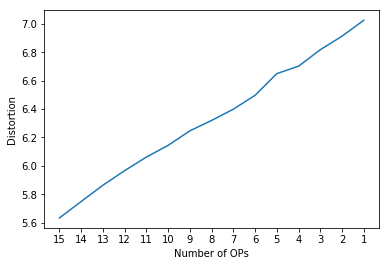

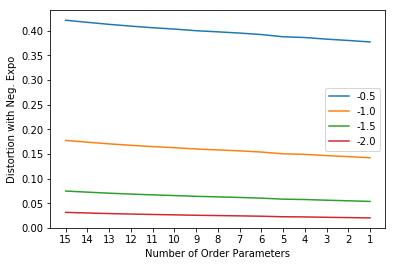

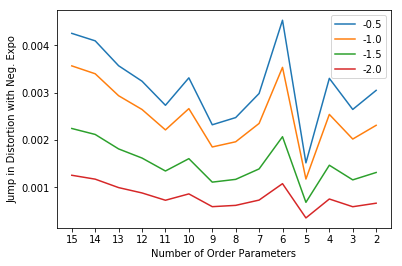

Center: d15_17
d15_17

Center: d2_5
d2_5
d2_6

Center: d2_7
d2_7
d2_9

Center: d11_15
d11_15

Center: d16_19
d15_19
d16_17
d16_19

Center: d5_17
d2_11
d2_15
d2_16
d2_17
d2_19
d5_11
d5_15
d5_16
d5_17
d5_19
d6_11
d6_15
d6_16
d6_17
d6_19
d7_15
d7_16
d7_17
d7_19
d11_16
d11_17
d11_19

Center: d9_17
d9_17
d9_19

Center: d15_16
d15_16

Center: d7_9
d7_9

Center: d5_6
d5_6

Center: d5_7
d5_7

Center: d9_15
d9_15
d9_16

Center: d7_11
d7_11
d9_11

Center: d6_9
d5_9
d6_7
d6_9

Center: d17_19
d17_19

d15_17
d2_5
d2_7
d11_15
d16_19
d5_17
d9_17
d15_16
d7_9
d5_6
d5_7
d9_15
d7_11
d6_9
d17_19


In [30]:
for i in ops:
    print(i.name)

final = find_ops(ops, 15)
for i in final:
    print(i.name)